In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [2]:
latent_dim = 5
vector_dim = 2

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(vector_dim, 10),
            nn.ReLU(),
            
            nn.Linear(10, 10),
            nn.ReLU(),
            
            nn.Linear(10, latent_dim),
            nn.Tanh()
        )
    def forward(self, x):
        return self.seq(x)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(latent_dim, 10),
            nn.ReLU(),
            
            nn.Linear(10, 10),
            nn.ReLU(),
            
            nn.Linear(10, vector_dim)
        )
    def forward(self, x):
        return self.seq(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.seq = nn.Sequential(
            #nn.Linear(vector_dim+latent_dim, 5),
            nn.Linear(vector_dim, 10),
            nn.LeakyReLU(0.1),
            
            nn.Linear(10, 10),
            nn.LeakyReLU(0.1),
            
            nn.Linear(10, 1),
            nn.Sigmoid()
        )
    #def forward(self, x, z):
    #   return self.seq(torch.cat([x, z], 1))
    
    
    def forward(self, x):
        return self.seq(x)

In [6]:
torch.manual_seed(1)
c1 = torch.cat([0.1*torch.randn(20000, 1)+2, 0.1*torch.randn(20000, 1)+0], 1)
c2 = torch.cat([0.1*torch.randn(20000, 1)-2, 0.1*torch.randn(20000, 1)+0], 1)

c3 = torch.cat([0.1*torch.randn(20000, 1)+0, 0.1*torch.randn(20000, 1)+2], 1)
c4 = torch.cat([0.1*torch.randn(20000, 1)+0, 0.1*torch.randn(20000, 1)-2], 1)

c5 = torch.cat([0.1*torch.randn(20000, 1)-np.sqrt(2), 0.1*torch.randn(20000, 1)-np.sqrt(2)], 1)
c6 = torch.cat([0.1*torch.randn(20000, 1)-np.sqrt(2), 0.1*torch.randn(20000, 1)+np.sqrt(2)], 1)

c7 = torch.cat([0.1*torch.randn(20000, 1)+np.sqrt(2), 0.1*torch.randn(20000, 1)-np.sqrt(2)], 1)
c8 = torch.cat([0.1*torch.randn(20000, 1)+np.sqrt(2), 0.1*torch.randn(20000, 1)+np.sqrt(2)], 1)

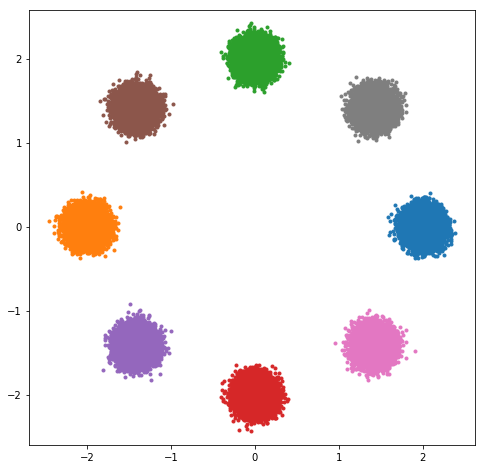

In [7]:
plt.gcf().set_size_inches(8, 8)

plt.scatter(c1[:,0].numpy(), c1[:,1].numpy(), marker='.')
plt.scatter(c2[:,0].numpy(), c2[:,1].numpy(), marker='.')
plt.scatter(c3[:,0].numpy(), c3[:,1].numpy(), marker='.')
plt.scatter(c4[:,0].numpy(), c4[:,1].numpy(), marker='.')
plt.scatter(c5[:,0].numpy(), c5[:,1].numpy(), marker='.')
plt.scatter(c6[:,0].numpy(), c6[:,1].numpy(), marker='.')
plt.scatter(c7[:,0].numpy(), c7[:,1].numpy(), marker='.')
plt.scatter(c8[:,0].numpy(), c8[:,1].numpy(), marker='.')
plt.axis('equal')
plt.show()

In [8]:
device = 'cuda'

In [9]:
dataset = TensorDataset(torch.cat([c1, c2, c3, c4, c5, c6, c7, c8]).to(device))
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)

In [10]:
G = Generator().to(device)
D = Discriminator().to(device)
E = Encoder().to(device)

In [11]:
adver_criterion = nn.BCELoss().to(device)
recon_criterion = nn.MSELoss(reduction='sum').to(device)

In [12]:
D_optimizer = optim.Adam(D.parameters(), lr=0.001)
G_optimizer = optim.Adam(G.parameters(), lr=0.001)
E_optimizer = optim.Adam(E.parameters(), lr=0.001)

In [13]:
losses = {
    'D':[],
    'G':[],
    'E':[],
    'I':[]
}

for _ in range(100):
    for idx, (x, ) in enumerate(dataloader):
        batch_size = x.shape[0]
        x_real = x.detach().to(device)
        
        # Train D
        D.zero_grad()
        
        z_real = E(x_real).detach()
        z_fake = 2*torch.rand(batch_size, latent_dim).to(device)-1
        x_fake = G(z_fake).detach()
        
        real_pred = D(x_real)#, z_real)
        fake_pred = D(x_fake)#, z_fake)
        
        d_real_target = torch.ones(batch_size, 1).to(device)
        d_fake_target = torch.zeros(batch_size, 1).to(device)
        
        D_loss = adver_criterion(fake_pred, d_fake_target) + adver_criterion(real_pred, d_real_target)
        D_loss.backward()
        D_optimizer.step()
        
        # Train G
        G.zero_grad()
        
        z_fake = 2*torch.rand(batch_size, latent_dim).to(device)-1
        x_fake = G(z_fake)
        fake_pred = D(x_fake)#, z_fake)
        g_target = d_fake_target.clone()
        
        G_loss = -adver_criterion(fake_pred, g_target)
        G_loss.backward()
        G_optimizer.step()
        
        # Train E
        E.zero_grad()
        
        z_real = E(x_real)
        real_pred = D(x_real)#, z_real)
        
        e_target = torch.ones(batch_size, 1).to(device)
        E_loss = adver_criterion(real_pred, e_target)
        
        E_loss.backward()
        E_optimizer.step()
        
        # latent identity Loss
        E.zero_grad()
        G.zero_grad()
        
        z_real = E(x_real)
        x_recon = G(z_real)
        z_recon = E(x_recon)

        I_loss =  recon_criterion(x_recon, x_real) + recon_criterion(z_recon, z_real)
        
        #I_loss.backward(retain_graph=True)
        #E_optimizer.step()
        #G_optimizer.step()
        
        losses['D'].append(D_loss.item())
        losses['G'].append(G_loss.item())
        losses['E'].append(E_loss.item())
        losses['I'].append(I_loss.item())


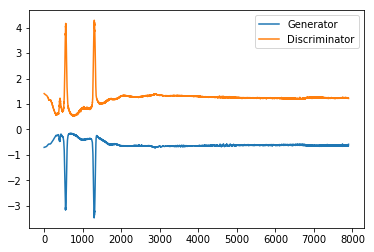

In [14]:
plt.plot(losses['G'], label='Generator')
plt.plot(losses['D'], label='Discriminator')
plt.legend()
plt.show()

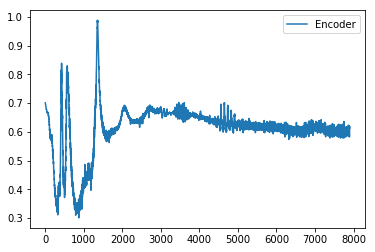

In [15]:
plt.plot(losses['E'], label='Encoder')
plt.legend()
plt.show()

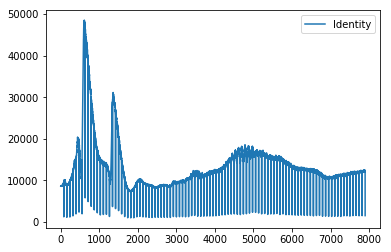

In [16]:
plt.plot(losses['I'], label='Identity')
plt.legend()
plt.show()

In [17]:
G.eval()
E.eval()

Encoder(
  (seq): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=5, bias=True)
    (5): Tanh()
  )
)

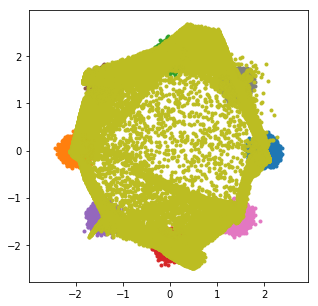

In [18]:
plt.gcf().set_size_inches(5, 5)
plt.scatter(c1[:,0].numpy(), c1[:,1].numpy(), marker='.')
plt.scatter(c2[:,0].numpy(), c2[:,1].numpy(), marker='.')
plt.scatter(c3[:,0].numpy(), c3[:,1].numpy(), marker='.')
plt.scatter(c4[:,0].numpy(), c4[:,1].numpy(), marker='.')
plt.scatter(c5[:,0].numpy(), c5[:,1].numpy(), marker='.')
plt.scatter(c6[:,0].numpy(), c6[:,1].numpy(), marker='.')
plt.scatter(c7[:,0].numpy(), c7[:,1].numpy(), marker='.')
plt.scatter(c8[:,0].numpy(), c8[:,1].numpy(), marker='.')
generated = G(2*torch.rand(100000, latent_dim).to(device)-1).detach().cpu().numpy()
plt.scatter(generated[:,0], generated[:,1], marker='.')
plt.axis('equal')
plt.show()

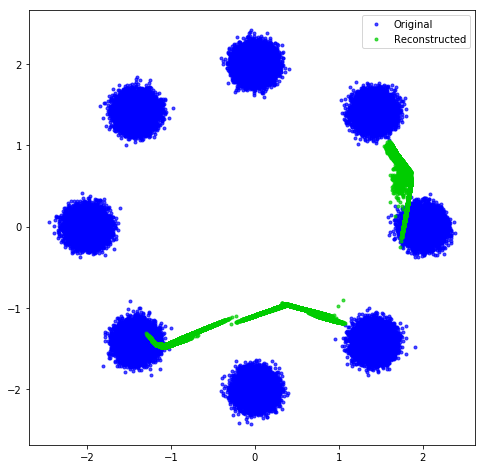

In [19]:
plt.gcf().set_size_inches(8, 8)

plt.scatter(c1[:,0].numpy(), c1[:,1].numpy(), marker='.', color=(0,0,1,0.7), label='Original')
plt.scatter(c2[:,0].numpy(), c2[:,1].numpy(), marker='.', color=(0,0,1,0.7))
plt.scatter(c3[:,0].numpy(), c3[:,1].numpy(), marker='.', color=(0,0,1,0.7))
plt.scatter(c4[:,0].numpy(), c4[:,1].numpy(), marker='.', color=(0,0,1,0.7))
plt.scatter(c5[:,0].numpy(), c5[:,1].numpy(), marker='.', color=(0,0,1,0.7))
plt.scatter(c6[:,0].numpy(), c6[:,1].numpy(), marker='.', color=(0,0,1,0.7))
plt.scatter(c7[:,0].numpy(), c7[:,1].numpy(), marker='.', color=(0,0,1,0.7))
plt.scatter(c8[:,0].numpy(), c8[:,1].numpy(), marker='.', color=(0,0,1,0.7))

recon = G((E(c1[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.', label='Reconstructed')

recon = G((E(c2[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.')

recon = G((E(c3[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.')

recon = G((E(c4[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.')

recon = G((E(c5[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.')

recon = G((E(c6[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.')

recon = G((E(c7[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.')

recon = G((E(c8[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.')

plt.legend()
plt.savefig('adhoc-gan.png', dpi=120, transparent=True, bbox_inches='tight')
plt.show()

In [20]:
G.eval()
E_post = Encoder().to(device)
ft_optimizer = optim.Adam(E_post.parameters(), lr=0.001)
for it in range(10000):
    target = 2*torch.rand(2048, latent_dim).to(device)-1
    image = G(target).detach()
    E_post.zero_grad()
    ft_loss = recon_criterion(E_post(image), target) + recon_criterion(E_post(G(E_post(image))), target)
    ft_loss.backward()
    ft_optimizer.step()

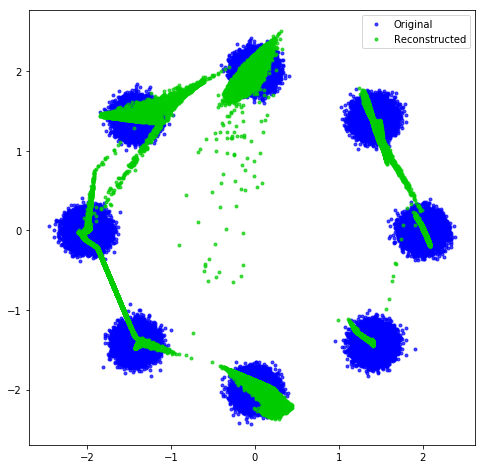

In [21]:
plt.gcf().set_size_inches(8, 8)

plt.scatter(c1[:,0].numpy(), c1[:,1].numpy(), marker='.', color=(0,0,1,0.7), label='Original')
plt.scatter(c2[:,0].numpy(), c2[:,1].numpy(), marker='.', color=(0,0,1,0.7))
plt.scatter(c3[:,0].numpy(), c3[:,1].numpy(), marker='.', color=(0,0,1,0.7))
plt.scatter(c4[:,0].numpy(), c4[:,1].numpy(), marker='.', color=(0,0,1,0.7))
plt.scatter(c5[:,0].numpy(), c5[:,1].numpy(), marker='.', color=(0,0,1,0.7))
plt.scatter(c6[:,0].numpy(), c6[:,1].numpy(), marker='.', color=(0,0,1,0.7))
plt.scatter(c7[:,0].numpy(), c7[:,1].numpy(), marker='.', color=(0,0,1,0.7))
plt.scatter(c8[:,0].numpy(), c8[:,1].numpy(), marker='.', color=(0,0,1,0.7))

recon = G((E_post(c1[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.', label='Reconstructed')

recon = G((E_post(c2[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.')

recon = G((E_post(c3[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.')

recon = G((E_post(c4[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.')

recon = G((E_post(c5[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.')

recon = G((E_post(c6[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.')

recon = G((E_post(c7[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.')

recon = G((E_post(c8[:].to(device)))).detach().cpu().numpy()
plt.scatter(recon[:,0], recon[:,1], color=(0,0.8,0,0.7), marker='.')

plt.legend()
plt.savefig('posthoc-gan.png', dpi=120, transparent=True, bbox_inches='tight')
plt.show()

In [22]:
numTests = 5
G.eval()
E.eval()

Encoder(
  (seq): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=5, bias=True)
    (5): Tanh()
  )
)

In [23]:
ad_losses, post_losses = [], []
for test in range(numTests):
    torch.manual_seed(test + 10)
    t1 = torch.cat([0.1*torch.randn(1000, 1)+2, 0.1*torch.randn(1000, 1)+0], 1)
    t2 = torch.cat([0.1*torch.randn(1000, 1)-2, 0.1*torch.randn(1000, 1)+0], 1)
    t3 = torch.cat([0.1*torch.randn(1000, 1)+0, 0.1*torch.randn(1000, 1)+2], 1)
    t4 = torch.cat([0.1*torch.randn(1000, 1)+0, 0.1*torch.randn(1000, 1)-2], 1)
    t5 = torch.cat([0.1*torch.randn(1000, 1)-np.sqrt(2), 0.1*torch.randn(1000, 1)-np.sqrt(2)], 1)
    t6 = torch.cat([0.1*torch.randn(1000, 1)-np.sqrt(2), 0.1*torch.randn(1000, 1)+np.sqrt(2)], 1)
    t7 = torch.cat([0.1*torch.randn(1000, 1)+np.sqrt(2), 0.1*torch.randn(1000, 1)-np.sqrt(2)], 1)
    t8 = torch.cat([0.1*torch.randn(1000, 1)+np.sqrt(2), 0.1*torch.randn(1000, 1)+np.sqrt(2)], 1)
    test_dataset = TensorDataset(torch.cat([t1,t2,t3,t4,t5,t6,t7,t8]).to(device))
    test_dataloader = DataLoader(test_dataset, batch_size=2048)

    E_post = Encoder().to(device)
    ft_optimizer = optim.Adam(E_post.parameters(), lr=0.001)
    for it in range(10000):
        target = 2*torch.rand(2048, latent_dim).to(device)-1
        image = G(target).detach()
        E_post.zero_grad()
        ft_loss = recon_criterion(E_post(image), target) + recon_criterion(E_post(G(E_post(image))), target)
        ft_loss.backward()
        ft_optimizer.step()
        
    E_post.eval()

    ad_loss, post_loss = 0, 0
    for idx, (x, ) in enumerate(test_dataloader):
        batch_size = x.shape[0]
        x_real = x.detach().to(device)
        ad_loss += recon_criterion(G(E(x_real)), x_real).item()
        post_loss += recon_criterion(G(E_post(x_real)), x_real).item()
    ad_loss, post_loss = ad_loss/len(test_dataset), post_loss/len(test_dataset)
    ad_losses.append(ad_loss)
    post_losses.append(post_loss)

In [24]:
(np.mean(ad_losses), np.std(ad_losses)), (np.mean(post_losses), np.std(post_losses))

((5.812696398925781, 0.0038214201289607256),
 (0.08127818021774291, 0.022343530077033085))